In [1]:
"""
We need this cell for reasons. . . .
"""

import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import suggest_cable_shift_double_ended
from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
import numpy as np
from dtscalibration import shift_double_ended

%matplotlib inline

# 0. First, we adjust the temperature measurements so that the Stokes and Anti-Stokes scatter is aligned.

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2471)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.27497e+02, 6.27751e+02,
       6.28006e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 627.2 627.5 627.8 628.0
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2469)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.26989e+02, 6.27243e+02,
       6.27497e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 626.7 627.0 627.2 62

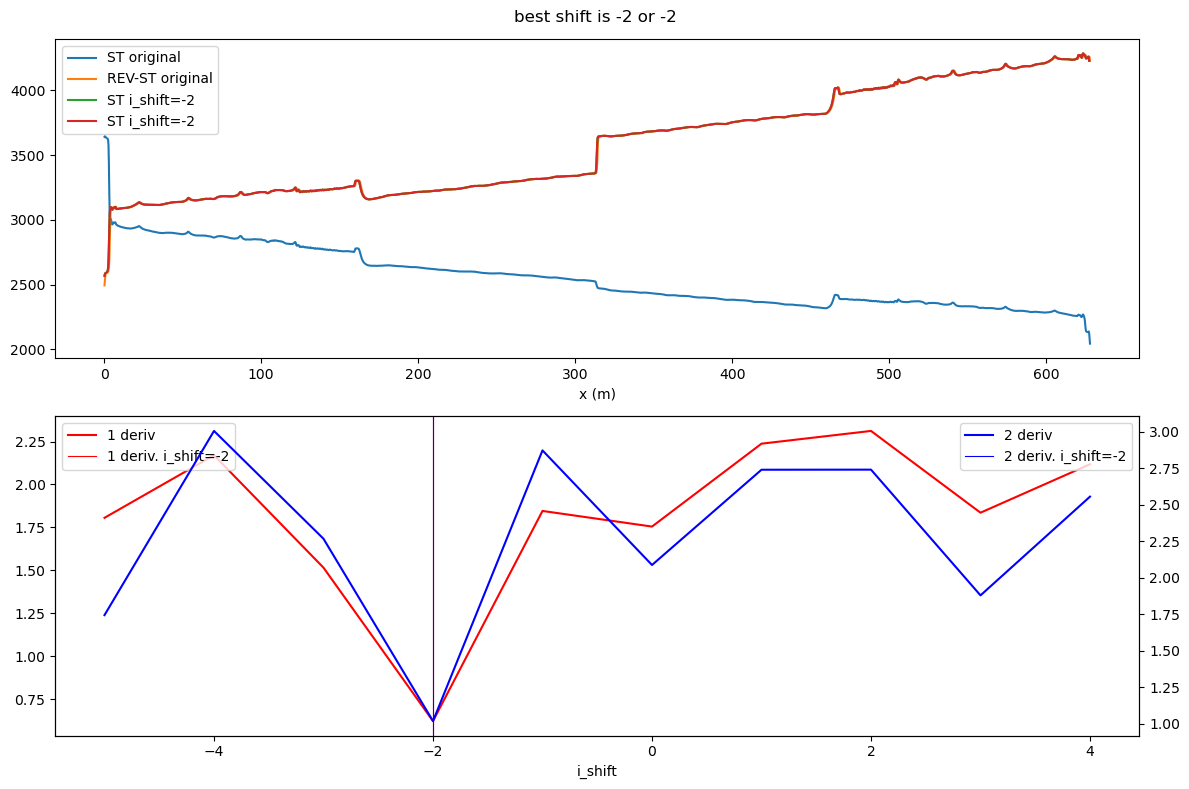

In [2]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628.2))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds_.sections = sections
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')


# 1. DTS data messaging

<IPython.core.display.Javascript object>


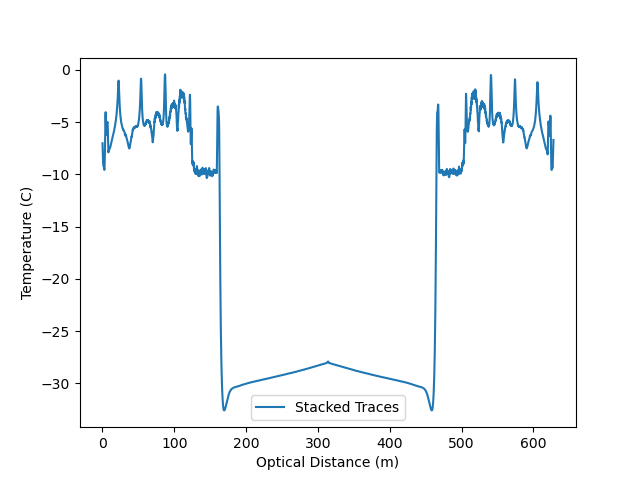

In [4]:
top_trend = 182 #optical distance (m), This is what we think the start of the long term signal is.
bottom_trend = 312.5 #optical distance (m), This is the bottom of the trend just above the warm bottom anomaly..
start_of_borehole = 162 #optical distance (m), Top of the borehole.

mean_sig1 = (ds.isel(time=0).tmpw + ds.isel(time=0).tmpw[::-1])/2
mean_sig2 = (ds.isel(time=1).tmpw + ds.isel(time=1).tmpw[::-1])/2
mean_sig3 = (ds.isel(time=2).tmpw + ds.isel(time=2).tmpw[::-1])/2

mean_tot = (mean_sig1 + mean_sig2 + mean_sig3) / 3


%matplotlib notebook

fig, ax = plt.subplots()
#plt.style.use('dark_background')
ax.plot(ds.x, mean_tot, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Optical Distance (m)')
# plt.xlim([top_trend, bottom_trend])
# plt.ylim([-31,-28])
plt.legend()

<IPython.core.display.Javascript object>


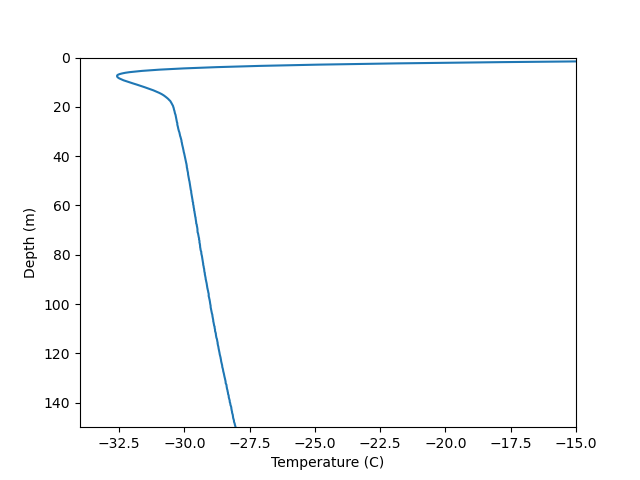

In [5]:
borehole_below_season = mean_tot.sel(x=slice(top_trend,bottom_trend))

%matplotlib notebook

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
plt.xlim([-34,-15])
plt.show()
#plt.legend()

## 1.1 We remove the linear fit from the signal which should leave just the climate variations.

43.487223276919885
-33.536320106385396


<IPython.core.display.Javascript object>


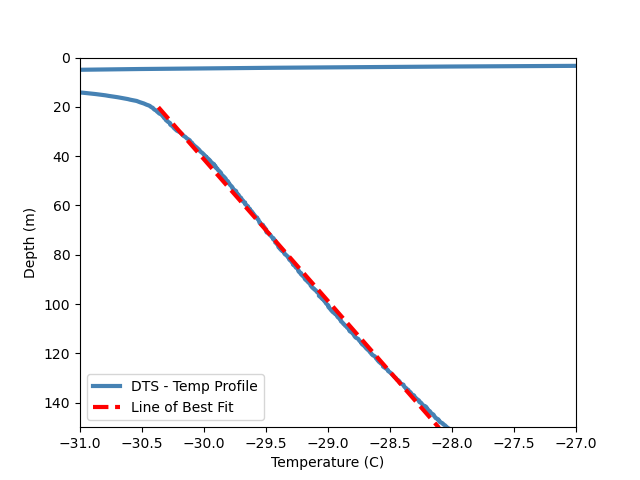

In [86]:
#Geothermal flux from a linear fit

#Where do we want to start the linear best fit relatively to the top of what we think the trend is?

start_here = 0   # 0 is the start of the top of the trend

m,b = np.polyfit(mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x, 
                 mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)), 1)

Q_geo = m *2.5*1e3
print(Q_geo)
print(b)

x  = m*mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x + b

y  = m*mean_tot.sel(x=slice(top_trend,bottom_trend)).x + b
anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y


#Full signal
# y  = m*mean_tot.sel(x=slice(top_trend,bottom_trend)).x + b
# anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y



#plot the geothermal heat flux
%matplotlib notebook

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'DTS - Temp Profile', lw = 3, c='steelblue')
ax.plot(x, mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x - start_of_borehole, label = 'Line of Best Fit', ls="--", lw = 3, c='red')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
ax.set_xlim([-31,-27])
plt.legend()

## 1.2 Use detrend to remove the linear fit and plot.

<IPython.core.display.Javascript object>


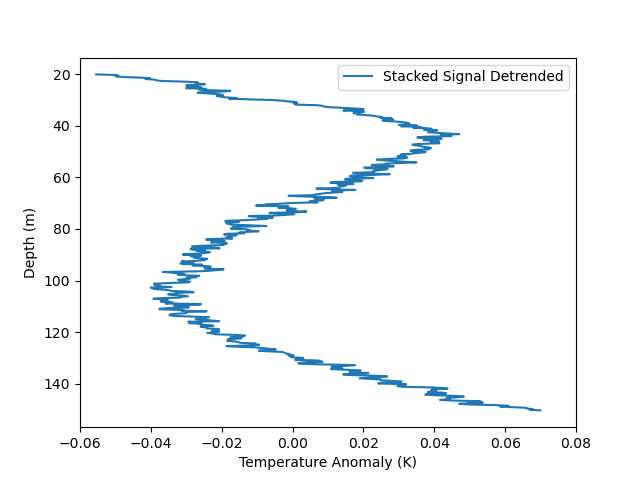

In [87]:
import scipy

detrend = scipy.signal.detrend(mean_tot.sel(x=slice(top_trend,bottom_trend)), type='linear', bp=0, overwrite_data=False)

%matplotlib notebook

fig, ax = plt.subplots()
#plt.style.use('dark_background')
ax.plot( detrend, borehole_below_season.x - start_of_borehole, label = 'Stacked Signal Detrended')


ax.set_xlabel('Temperature Anomaly (K)')
ax.set_ylabel('Depth (m)')


ax.invert_yaxis()
ax.set_xlim([-.06,0.08])
plt.legend()

# 2.0 Now, set up the forward model of borehole temps

In [162]:
from heat import *
from tqdm import tqdm
import numpy as np
import copy
#Parameters
restarts = 3
iterations = 20
nt = 100


tmax = 2023
tmin = 1823
zmax = bottom_trend - top_trend#150
dTdz = 0.046
nz = len(mean_tot.sel(x=slice(top_trend,bottom_trend))) -1
nt = nt
alpha = 35 * ((tmax - tmin) / (nt)) #originally was just 35
accumulation = 0

# t_surf = np.eye(nt)

# A = np.zeros((nt+1,nz+1))
m_not_accepted = []
m_accepted_all = []
best_of_restart = []
predicted_data = []

for i in tqdm(range(restarts)):
    val_gauss = np.random.normal(loc=0,scale=1, size=nt)
    m_i = np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))  
    m_accepted = [m_i]
    for j in range(iterations): #this was for i in range(nt)
        
        m_next_copy = copy.deepcopy(m_accepted[-1])
        val_gauss = np.random.normal(loc=0,scale=1, size=nt)
        change = (np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))) 

        this_t_surf = (m_next_copy + change) * .02
    #     if i == 20: this_t_surf = 10*this_t_surf
    
#         plt.figure()
#         plt.plot(range(m_next_copy.shape[0]), this_t_surf)
        
        U,t,z = heat(this_t_surf,
             tmax = tmax,
             tmin = tmin,
             zmax = zmax,
             dTdz = dTdz,
             nz = nz,
             nt = nt,
             alpha = alpha,
             accumulation = accumulation)
        now = detrend(U[:,-1])
        
        
#         plt.figure()
#         plt.plot(now, z)
#         plt.plot(d_obs, z)
        
        r = sum(np.abs(now - d_obs))
        print(r)
        sigma = 1 * np.sqrt(len(this_t_surf))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###

        if L > alpha:
#             r_values.append(r)
            m_accepted_all.append(this_t_surf)
            predicted_data.append(now)
            m_accepted.append(this_t_surf)
            #print('r = ' + str(r))
            print('L = '+ str(L)+'  , alpha = '+str(alpha))
            print("accepted")
        if L < alpha:
            m_not_accepted.append(m_next_copy)
#         A[i,:] = now

    best_of_restart.append(m_accepted[-1])
# A = A.T
#     print(z.shape)
#     heat_plot(t, t_surf, 0, 1000, z, U)

  0%|          | 0/3 [00:00<?, ?it/s]

17.109760062014058
12.507261829317475
23.462986523018035
14.833201632853761
33.85245434471151
13.73092104129536
12.667284324749602
14.213004539837115
11.95863467155668
17.136316857397503
13.409145006025287
14.012417231705712
16.463665483358582
13.893702096371209
L = 0.015196374247813707  , alpha = 0.0021091015630435583
accepted
12.86077147112471
16.48162436508208
11.314341385962699
16.816497553583766
12.89273295805899


 33%|███▎      | 1/3 [00:56<01:53, 56.89s/it]

14.276062091925006
13.096801445954565
15.860011070662168
35.58148805706663
17.05007068426081
19.635708656605857
14.130598312165354
33.895940110908555
13.837890478632417
15.900272199898506
22.938354344434945
13.904190464880688
11.375813180818259
17.744648984869137
19.39329620385971
12.883286096386021
13.481693851261374
11.764561131821816
13.795300635461963
11.917185829749947


 67%|██████▋   | 2/3 [01:53<00:56, 56.90s/it]

12.240358164164611
12.977801990299426
29.52724178005126
28.67729110594886
30.454850747821382
28.37236380656178
21.85591029723211
17.5559762462037
12.194388593457926
26.16867229427185
22.95635240598073
13.703092153319353
23.556385298157366
21.69188923749593
37.06860320199988
25.009147754035585
41.53585462295024
20.025313745949315
16.956613336070955
13.033049904321786


100%|██████████| 3/3 [02:50<00:00, 56.90s/it]

38.15683092650291


<IPython.core.display.Javascript object>


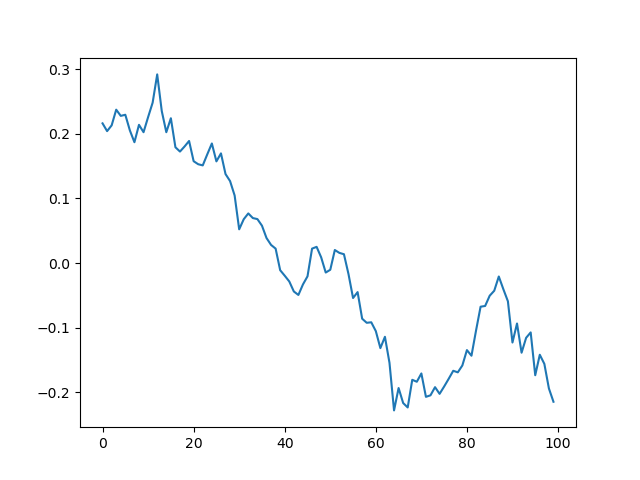

In [163]:
plt.figure()
plt.plot(np.asarray(m_accepted_all).T)

plt.show()

<IPython.core.display.Javascript object>


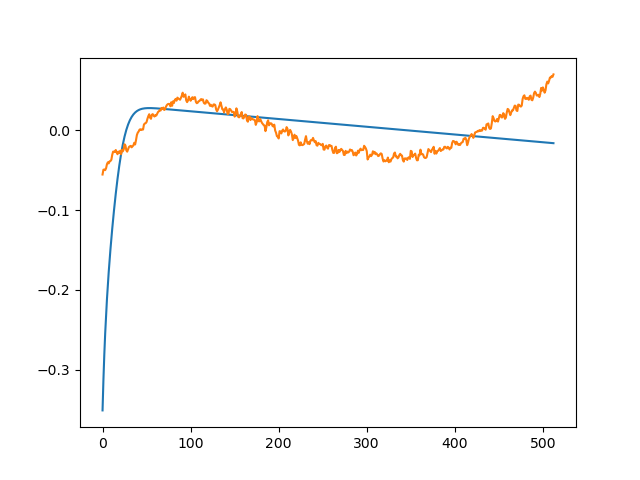

In [164]:
plt.figure()
plt.plot(np.asarray(predicted_data).T)
plt.plot(d_obs)

plt.show()

# 2.0 Now, set up the forward model of borehole temps
### But what if we model the full profile and remove the seasonal signal after the forward model?

In [231]:
from heat import *
from tqdm import tqdm
import numpy as np
import copy
#Parameters
restarts = 10
iterations = 100
nt = 100


tmax = 2023
tmin = 1923
zmax = bottom_trend - start_of_borehole#150
dTdz = 0.046
nz = len(mean_tot.sel(x=slice(start_of_borehole,bottom_trend))) -1
nt = nt
diffusivity = 35 * ((tmax - tmin) / (nt)) #originally was just 35
accumulation = 0

# t_surf = np.eye(nt)

# A = np.zeros((nt+1,nz+1))
m_not_accepted = []
m_accepted_all = []
best_of_restart = []
predicted_data = []
temperature_histories = []

for i in tqdm(range(restarts)):
    val_gauss = np.random.normal(loc=0,scale=3, size=nt)
    m_i = np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))  
    m_accepted = [m_i]
    for j in range(iterations): #this was for i in range(nt)
        
        m_next_copy = copy.deepcopy(m_accepted[-1])
        val_gauss = np.random.normal(loc=0,scale=1, size=nt)
        change = (np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))) 

        this_t_surf = (m_next_copy + change) * .02
    #     if i == 20: this_t_surf = 10*this_t_surf
        temperature_histories.append(this_t_surf)
    
#         plt.figure()
#         plt.plot(range(m_next_copy.shape[0]), this_t_surf)
        
        U,t,z = heat(this_t_surf,
             tmax = tmax,
             tmin = tmin,
             zmax = zmax,
             dTdz = dTdz,
             nz = nz,
             nt = nt,
             alpha = diffusivity,
             accumulation = accumulation)
        

        season_size = U[:,-1].shape[0] - len(d_obs)
#         plt.figure()
# #         plt.plot(z, U[:,-1])
# #         plt.plot(z[season_size:], U[:,-1][season_size:])
#         plt.plot(z[season_size:], detrend(U[:,-1][season_size:]))
        now = detrend(U[:,-1][season_size:])
#         print(now.shape)
        
#         plt.figure()
#         plt.imshow(U, aspect='auto', vmin=-0.5, vmax=0.5)
#         plt.plot(now)
#         plt.plot(d_obs)

        
        r = sum(np.abs(now - d_obs))
        print(r)
        sigma = 1 * np.sqrt(len(this_t_surf))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###

        if L > alpha:
#             r_values.append(r)
            m_accepted_all.append(this_t_surf)
            predicted_data.append(now)
            m_accepted.append(this_t_surf)
            #print('r = ' + str(r))
            print('L = '+ str(L)+'  , alpha = '+str(alpha))
            print("accepted")
        if L < alpha:
            m_not_accepted.append(m_next_copy)
#         A[i,:] = now

    best_of_restart.append(m_accepted[-1])
# A = A.T
#     print(z.shape)
#     heat_plot(t, t_surf, 0, 1000, z, U)

  0%|          | 0/10 [00:00<?, ?it/s]

29.540234666429257
29.44309594092009
34.639020050322564
25.973497492724732
29.894421122311297
32.14880366640705
34.48028039862722
45.26679845608271
31.883830453858405
32.519429665492964
23.00500547478768
28.43617836637818
35.6117501795497
29.423052449569305
25.17867137362989
34.644026168621274
33.62197340019322
34.03046747675538
32.882866292143625
33.63013699307826
33.360857735366494
37.051870237831466
32.24109140623115
39.92563069321059
35.34794481094736
32.609070436978605
31.25004074328163
26.41792507470666
32.83089679921325
29.95954406772519
25.90811594049872
30.113806649724125
35.6504367300113
24.87624456751174
31.139022672713807
30.341049154278203
36.35231213319352
45.21791001069894
33.0828543508469
34.464363111473475
36.013977804156816
31.287783826359533
26.88185290840306


  0%|          | 0/10 [02:24<?, ?it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


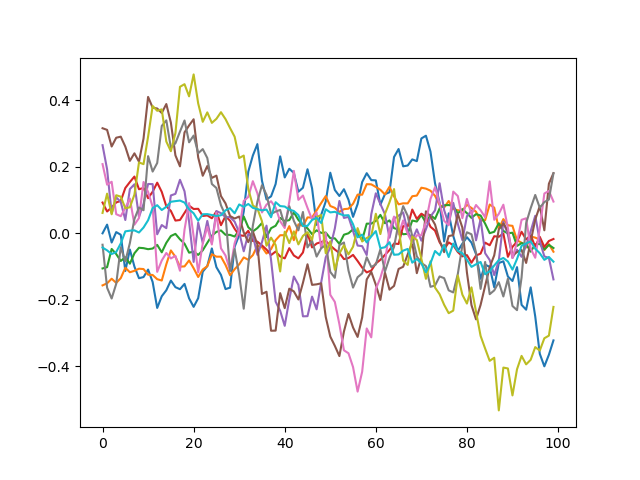

<IPython.core.display.Javascript object>


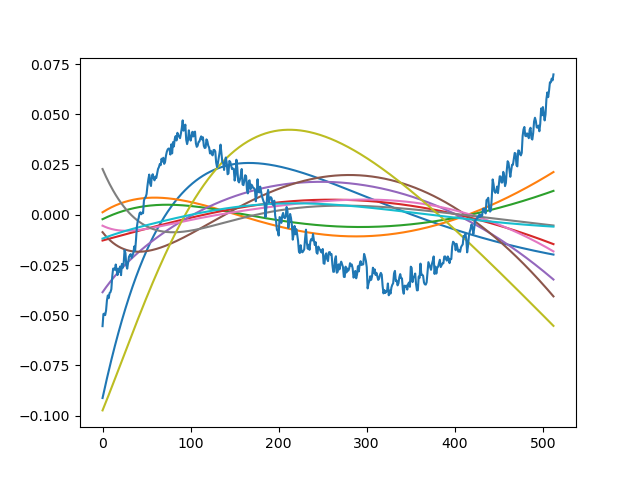

In [211]:
plt.figure()
plt.plot(np.asarray(m_accepted_all).T)

plt.show()

plt.figure()
plt.plot(np.asarray(predicted_data).T)
plt.plot(d_obs)

plt.show()

<IPython.core.display.Javascript object>


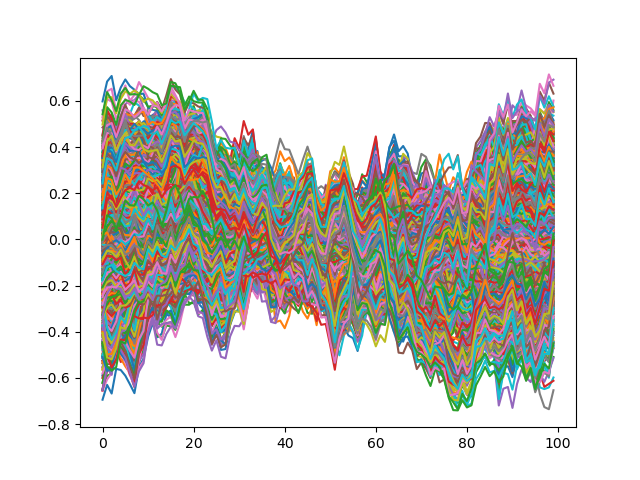

In [212]:
plt.figure()
plt.plot(np.asarray(temperature_histories).T)

## Can we parallize this now?

In [248]:
def hastings_met_brute(m, iterations=100):
    m_accepted = [m]
    val_gauss = np.random.normal(loc=0,scale=1, size=nt)
    change = (np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))) 
    for i in range(iterations):
        m_next_copy = copy.deepcopy(m_accepted[-1])
        this_t_surf = (m_next_copy + change) * .02
    #     if i == 20: this_t_surf = 10*this_t_surf
        temperature_histories.append(this_t_surf)

    #         plt.figure()
    #         plt.plot(range(m_next_copy.shape[0]), this_t_surf)

        U,t,z = heat(this_t_surf,
             tmax = tmax,
             tmin = tmin,
             zmax = zmax,
             dTdz = dTdz,
             nz = nz,
             nt = nt,
             alpha = diffusivity,
             accumulation = accumulation)


        season_size = U[:,-1].shape[0] - len(d_obs)
    #         plt.figure()
    # #         plt.plot(z, U[:,-1])
    # #         plt.plot(z[season_size:], U[:,-1][season_size:])
    #         plt.plot(z[season_size:], detrend(U[:,-1][season_size:]))
        now = detrend(U[:,-1][season_size:])
    #         print(now.shape)

    #         plt.figure()
    #         plt.imshow(U, aspect='auto', vmin=-0.5, vmax=0.5)
    #         plt.plot(now)
    #         plt.plot(d_obs)


        r = sum(np.abs(now - d_obs))
        print(r)
        sigma = 1 * np.sqrt(len(this_t_surf))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###
        print('L = '+ str(L))
        print('L_i = ' + str(Ls[-1]))
        if L > alpha:
    #             r_values.append(r)
            m_accepted_all.append(this_t_surf)
            predicted_data.append(now)
            m_accepted.append(this_t_surf)
            #print('r = ' + str(r))
            print('L = '+ str(L)+'  , alpha = '+str(alpha))
            print("accepted")
            Ls.append(L)
        if L < alpha:
            m_not_accepted.append(m_next_copy)


In [254]:
from pathos.multiprocessing import ProcessPool
import time

#Parameters
restarts = 100
iterations = 2
nt = 100


tmax = 2023
tmin = 1923
zmax = bottom_trend - start_of_borehole#150
dTdz = 0.046
nz = len(mean_tot.sel(x=slice(start_of_borehole,bottom_trend))) -1
nt = nt
diffusivity = 35 * ((tmax - tmin) / (nt)) #originally was just 35
accumulation = 0

# t_surf = np.eye(nt)

# A = np.zeros((nt+1,nz+1))
m_not_accepted = []
m_accepted_all = []
best_of_restart = []
predicted_data = []
temperature_histories = []

random_model_estimates = np.zeros((restarts, nt))

for i in range(restarts):
    val_gauss = np.random.normal(loc=0,scale=0.05, size=nt)
    m_i = np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss)) 
    random_model_estimates[i] = m_i

random_model_estimates = random_model_estimates.T  
# plt.figure()
# plt.plot(random_model_estimates)


pool = ProcessPool(nodes=4)
inputs = random_model_estimates
outputs = pool.map(hastings_met_brute, inputs)
print("Input: {}".format(inputs))
print("Output: {}".format(outputs))

KeyboardInterrupt: 

Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/tmp/ipykernel_369660/1386215073.py", line 22, in hastings_met_brute
    accumulation = accumulation)
  File "/home/jmanos/notebooks/Antarctica_DTS/heat.py", line 50, in heat
    

## 2.0.1 Same as above but we improve each time.

In [ ]:
from heat import *
from tqdm import tqdm
import numpy as np
import copy
#Parameters
restarts = 10
iterations = 5
nt = 100


tmax = 2023
tmin = 1923
zmax = bottom_trend - start_of_borehole#150
dTdz = 0 #0.046
nz = len(mean_tot.sel(x=slice(start_of_borehole,bottom_trend))) -1
nt = nt
diffusivity = 35 * ((tmax - tmin) / (nt)) #originally was just 35
accumulation = 0

# t_surf = np.eye(nt)

# A = np.zeros((nt+1,nz+1))
m_not_accepted = []
m_accepted_all = []
best_of_restart = []
predicted_data = []
temperature_histories = []

for i in tqdm(range(restarts)):
    val_gauss = np.random.normal(loc=0,scale=3, size=nt)
    m_i = np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss)) 

    sigma = 1 * np.sqrt(len(m_i))
    
    U,t,z = heat(m_i,
         tmax = tmax,
         tmin = tmin,
         zmax = zmax,
         dTdz = dTdz,
         nz = nz,
         nt = nt,
         alpha = diffusivity,
         accumulation = accumulation)


    season_size = U[:,-1].shape[0] - len(d_obs)
#         plt.figure()
# #         plt.plot(z, U[:,-1])
# #         plt.plot(z[season_size:], U[:,-1][season_size:])
#         plt.plot(z[season_size:], detrend(U[:,-1][season_size:]))
    now = detrend(U[:,-1][season_size:])
    #print(sigma)
    r_i = sum(np.abs(now - d_obs))
    L_i = np.exp(-r_i**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma

    m_accepted = [m_i]
    Ls = [L_i]
    for j in range(iterations): #this was for i in range(nt)
        
        m_next_copy = copy.deepcopy(m_accepted[-1])
        val_gauss = np.random.normal(loc=0,scale=1, size=nt)
        change = (np.cumsum(val_gauss) - np.mean(np.cumsum(val_gauss))) 

        this_t_surf = (m_next_copy + change) * .02
    #     if i == 20: this_t_surf = 10*this_t_surf
        temperature_histories.append(this_t_surf)
    
#         plt.figure()
#         plt.plot(range(m_next_copy.shape[0]), this_t_surf)
        
        U,t,z = heat(this_t_surf,
             tmax = tmax,
             tmin = tmin,
             zmax = zmax,
             dTdz = dTdz,
             nz = nz,
             nt = nt,
             alpha = diffusivity,
             accumulation = accumulation)
        

        season_size = U[:,-1].shape[0] - len(d_obs)
#         plt.figure()
# #         plt.plot(z, U[:,-1])
# #         plt.plot(z[season_size:], U[:,-1][season_size:])
#         plt.plot(z[season_size:], detrend(U[:,-1][season_size:]))
        now = detrend(U[:,-1][season_size:])
#         print(now.shape)
        
#         plt.figure()
#         plt.imshow(U, aspect='auto', vmin=-0.5, vmax=0.5)
#         plt.plot(now)
#         plt.plot(d_obs)

        
        r = sum(np.abs(now - d_obs))
        print(r)
        sigma = 1 * np.sqrt(len(this_t_surf))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###
        print('L = '+ str(L))
        print('L_i = ' + str(Ls[-1]))
        if L > Ls[-1]:
#             r_values.append(r)
            m_accepted_all.append(this_t_surf)
            predicted_data.append(now)
            m_accepted.append(this_t_surf)
            #print('r = ' + str(r))
            print('L = '+ str(L)+'  , alpha = '+str(alpha))
            print("accepted")
            Ls.append(L)
        if L < Ls[-1]:
            m_not_accepted.append(m_next_copy)
#         A[i,:] = now

    best_of_restart.append(m_accepted[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


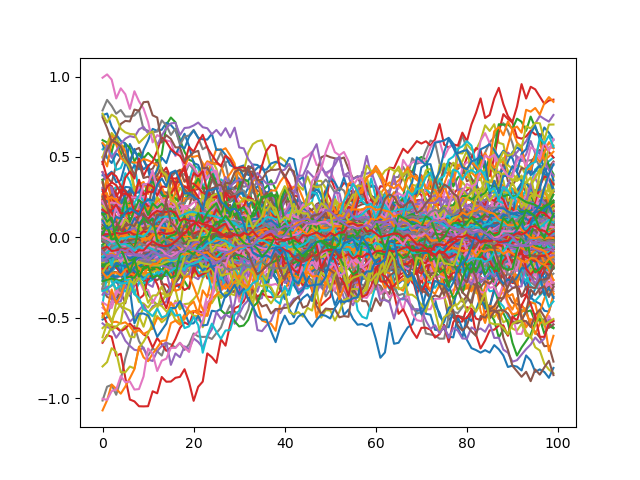

<IPython.core.display.Javascript object>


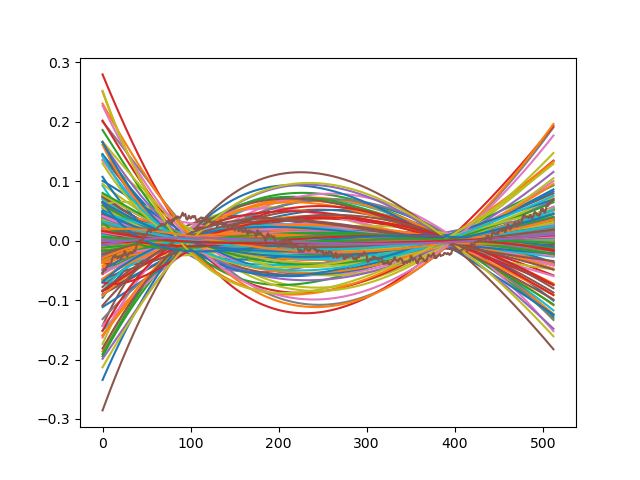

In [220]:
plt.figure()
plt.plot(np.asarray(m_accepted_all).T)

plt.show()

plt.figure()
plt.plot(np.asarray(predicted_data).T)
plt.plot(d_obs)

plt.show()

<IPython.core.display.Javascript object>


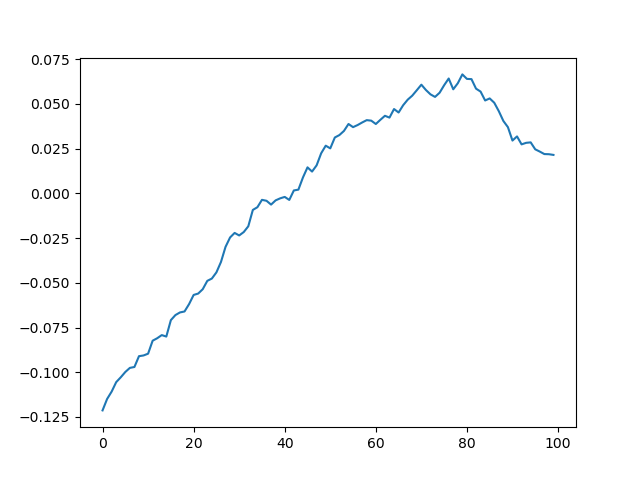

In [230]:
plt.figure()
# plt.plot(np.asarray(best_of_restart).T)
plt.plot(np.mean(np.asarray(best_of_restart).T, axis=1))
plt.show()


In [224]:
np.mean(np.asarray(best_of_restart).T, axis=0)

array([ 1.04083409e-19, -2.49800181e-18,  1.47104551e-17,  3.60822483e-18,
       -1.94289029e-18, -4.71844785e-18, -1.30451205e-17,  2.49800181e-17,
       -2.51187959e-17,  4.01068068e-17, -8.32667268e-19,  3.96817995e-17,
       -4.71844785e-18,  4.16333634e-19, -6.54337695e-17, -1.44328993e-17,
       -5.27355937e-18, -1.45716772e-18, -1.19175503e-17, -1.51907566e-17,
       -2.41473508e-17,  3.05311332e-18,  1.04083409e-17, -4.30211422e-18,
       -3.19189120e-18, -1.94289029e-18, -1.17267307e-17, -2.85882429e-17,
       -9.99200722e-18, -4.44089210e-18, -4.71150896e-17, -8.32667268e-19,
       -2.35922393e-17, -1.38777878e-19,  3.05311332e-18,  8.04911693e-18,
       -8.17922119e-18,  1.06858966e-17, -2.30371278e-17,  1.94289029e-18,
       -1.38777878e-18, -6.80011603e-18, -1.27328703e-17, -1.15879528e-17,
       -2.45636844e-17, -2.77555756e-18, -3.02535774e-17,  1.28369537e-18,
        9.02056208e-18,  7.21644966e-18, -7.63278329e-18,  4.99600361e-18,
        4.16333634e-19, -